# Profiling ray.put()

In [49]:
import ray
import cProfile
import pstats
import StringIO
import time
import sys
import string
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
ray.init()

Waiting for redis server at 127.0.0.1:38242 to respond...
Waiting for redis server at 127.0.0.1:26667 to respond...
Starting local scheduler with the following resources: {'GPU': 0, 'CPU': 4}.

View the web UI at http://localhost:8908/notebooks/ray_ui84491.ipynb?token=4eb95e4c975f91f340d48126ea7546961e21ae5fa09943ae



{'local_scheduler_socket_names': ['/tmp/scheduler41348786'],
 'node_ip_address': '127.0.0.1',
 'object_store_addresses': [ObjectStoreAddress(name='/tmp/plasma_store51442310', manager_name='/tmp/plasma_manager5184722', manager_port=12306)],
 'redis_address': '127.0.0.1:38242',
 'webui_url': 'http://localhost:8908/notebooks/ray_ui84491.ipynb?token=4eb95e4c975f91f340d48126ea7546961e21ae5fa09943ae'}

## Functions

In [12]:
def get_profile_data(arr):
    pr = cProfile.Profile()
    pr.enable()
    ray.put(arr)
    pr.disable()
    return pr

In [13]:
def stats_printer(profile_object):
    s = StringIO.StringIO()
    sortby = 'module'
    ps = pstats.Stats(profile_object, stream=s).sort_stats(sortby)
    ps.strip_dirs()
    ps.print_stats('put|plasma|store_and_register')
    print s.getvalue()

In [14]:
def print_profile_data_raw(arr):
    pr = get_profile_data(arr)
    stats_printer(pr)

In [38]:
def print_profile_data_clean(arr):
    profile_data = get_profile_data(arr)
    put = 0.0
    
    print 'ncalls' + '\t' + 'inlinetime' + '\t' +'tottime' + '\t' + '\t' + 'filename(function)'
    for line in profile_data.getstats():
        code = line.code
        if type(code) is not str:
            code = code.co_filename.split('/')[-1]+":"+code.co_name

        ncalls = line.callcount
        tottime = "%.6f" % line.totaltime
        inlinetime = "%.6f" % line.inlinetime
        
        if 'put' in code or 'plasma' in code or 'store_and_register' in code:
            print str(ncalls) + '\t' + str(inlinetime) + '\t' + str(tottime) + '\t' + str(code)

In [39]:
def get_put_time(arr):
    profile_data = get_profile_data(arr)
    put = 0.0
    
    for line in profile_data.getstats():
        code = line.code
        if type(code) is not str:
            code = code.co_filename.split('/')[-1]+":"+code.co_name
            
        if code == "<method 'put' of 'pyarrow.plasma.PlasmaClient' objects>":
            put = line.totaltime

    return put

## Test Inputs

In [40]:
NUM_STRINGS = 2*10**3
STRING_LENGTH = 20

short_numpy_array = np.array([1,2,3,4,5])
large_numpy_array = np.array([i for i in range(NUM_STRINGS)])
very_large_numpy_array = np.array([i for i in range(NUM_STRINGS * 10)])
large_string_array = [''.join(random.choice(string.ascii_letters) for _ in range(STRING_LENGTH)) for _ in range(NUM_STRINGS)]
array_of_large_integers = [np.random.randint(0, sys.maxsize) for _ in range(NUM_STRINGS * 10)]
large_string_array_asints = np.array([[ord(c) for c in s] for s in large_string_array], dtype=np.uint8)

In [41]:
print("Size of short numpy array: " + str(sys.getsizeof(short_numpy_array)/1024/1024) + " MB")
print("Size of large numpy array: " + str(sys.getsizeof(large_numpy_array)/1024/1024) + " MB")
print("Size of very large numpy array: " + str(sys.getsizeof(very_large_numpy_array)/1024/1024) + " MB")
print("Size of large string string: " + str(sys.getsizeof(large_string_array)/1024/1024) + " MB")
print("Size of large integer array: " + str(sys.getsizeof(array_of_large_integers)/1024/1024) + " MB")
print("Size of string array as ints: " + str(sys.getsizeof(large_string_array_asints)/1024/1024) + " MB")

Size of short numpy array: 0 MB
Size of large numpy array: 0 MB
Size of very large numpy array: 0 MB
Size of large string string: 0 MB
Size of large integer array: 0 MB
Size of string array as ints: 0 MB


## Profiling Results

In [42]:
print_profile_data_clean(short_numpy_array)

ncalls	inlinetime	tottime		filename(function)
1	0.000025	0.000025	<method 'compute_put_id' of 'local_scheduler.LocalSchedulerClient' objects>
1	0.000035	0.000875	worker.py:store_and_register
1	0.000009	0.000887	worker.py:put_object
1	0.000083	0.001129	worker.py:put
1	0.000839	0.000839	<method 'put' of 'pyarrow.plasma.PlasmaClient' objects>


In [43]:
print_profile_data_clean(large_numpy_array)

ncalls	inlinetime	tottime		filename(function)
1	0.000024	0.000024	<method 'compute_put_id' of 'local_scheduler.LocalSchedulerClient' objects>
1	0.000013	0.000802	worker.py:store_and_register
1	0.000003	0.000808	worker.py:put_object
1	0.000034	0.000900	worker.py:put
1	0.000788	0.000788	<method 'put' of 'pyarrow.plasma.PlasmaClient' objects>


In [44]:
print_profile_data_clean(very_large_numpy_array)

ncalls	inlinetime	tottime		filename(function)
1	0.000050	0.000050	<method 'compute_put_id' of 'local_scheduler.LocalSchedulerClient' objects>
1	0.000020	0.002952	worker.py:store_and_register
1	0.000009	0.002964	worker.py:put_object
1	0.000030	0.003103	worker.py:put
1	0.002932	0.002932	<method 'put' of 'pyarrow.plasma.PlasmaClient' objects>


In [45]:
print_profile_data_clean(large_string_array)

ncalls	inlinetime	tottime		filename(function)
1	0.000033	0.000033	<method 'compute_put_id' of 'local_scheduler.LocalSchedulerClient' objects>
1	0.000017	0.002896	worker.py:store_and_register
1	0.000006	0.002904	worker.py:put_object
1	0.000024	0.003005	worker.py:put
1	0.002878	0.002878	<method 'put' of 'pyarrow.plasma.PlasmaClient' objects>


In [46]:
print_profile_data_clean(array_of_large_integers)

ncalls	inlinetime	tottime		filename(function)
1	0.000031	0.000031	<method 'compute_put_id' of 'local_scheduler.LocalSchedulerClient' objects>
1	0.000021	0.004037	worker.py:store_and_register
1	0.000007	0.004046	worker.py:put_object
1	0.000024	0.004148	worker.py:put
1	0.004016	0.004016	<method 'put' of 'pyarrow.plasma.PlasmaClient' objects>


In [47]:
print_profile_data_clean(large_string_array_asints)

ncalls	inlinetime	tottime		filename(function)
1	0.000028	0.000028	<method 'compute_put_id' of 'local_scheduler.LocalSchedulerClient' objects>
1	0.000019	0.002474	worker.py:store_and_register
1	0.000006	0.002482	worker.py:put_object
1	0.000044	0.002594	worker.py:put
1	0.002455	0.002455	<method 'put' of 'pyarrow.plasma.PlasmaClient' objects>


## Plots

[1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]
[0.0005447000000000001, 0.00024209999999999995, 0.0011768, 0.0012046, 0.0005202999999999999, 0.0013662999999999998, 0.0062651, 0.0582652]


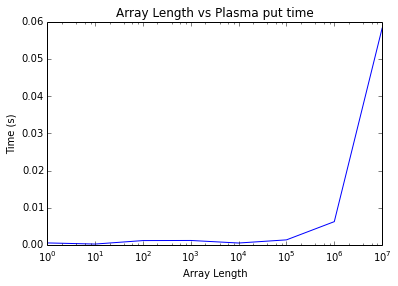

In [51]:
xs = [10**i for i in range(8)]
ys = []
for x in xs:
    samples = []
    for j in range(10):
        samples.append(get_put_time(np.array([i for i in range(x)])))
    ys.append(np.average(samples))
    
print(xs)
print(ys)

plt.title('Array Length vs Plasma put time')
plt.xlabel('Array Length')
plt.xscale('log')
plt.ylabel('Time (s)')
plt.plot(xs, ys)